In [23]:
import yfinance as yf
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow.keras as keras

In [25]:
# Get the data

start = dt.datetime(2010,1,1)
end = dt.datetime(2019,12,31)
stk_data = yf.download('NSE', start='2010-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [26]:
# looking at the data
stk_data.shape

(1822, 6)

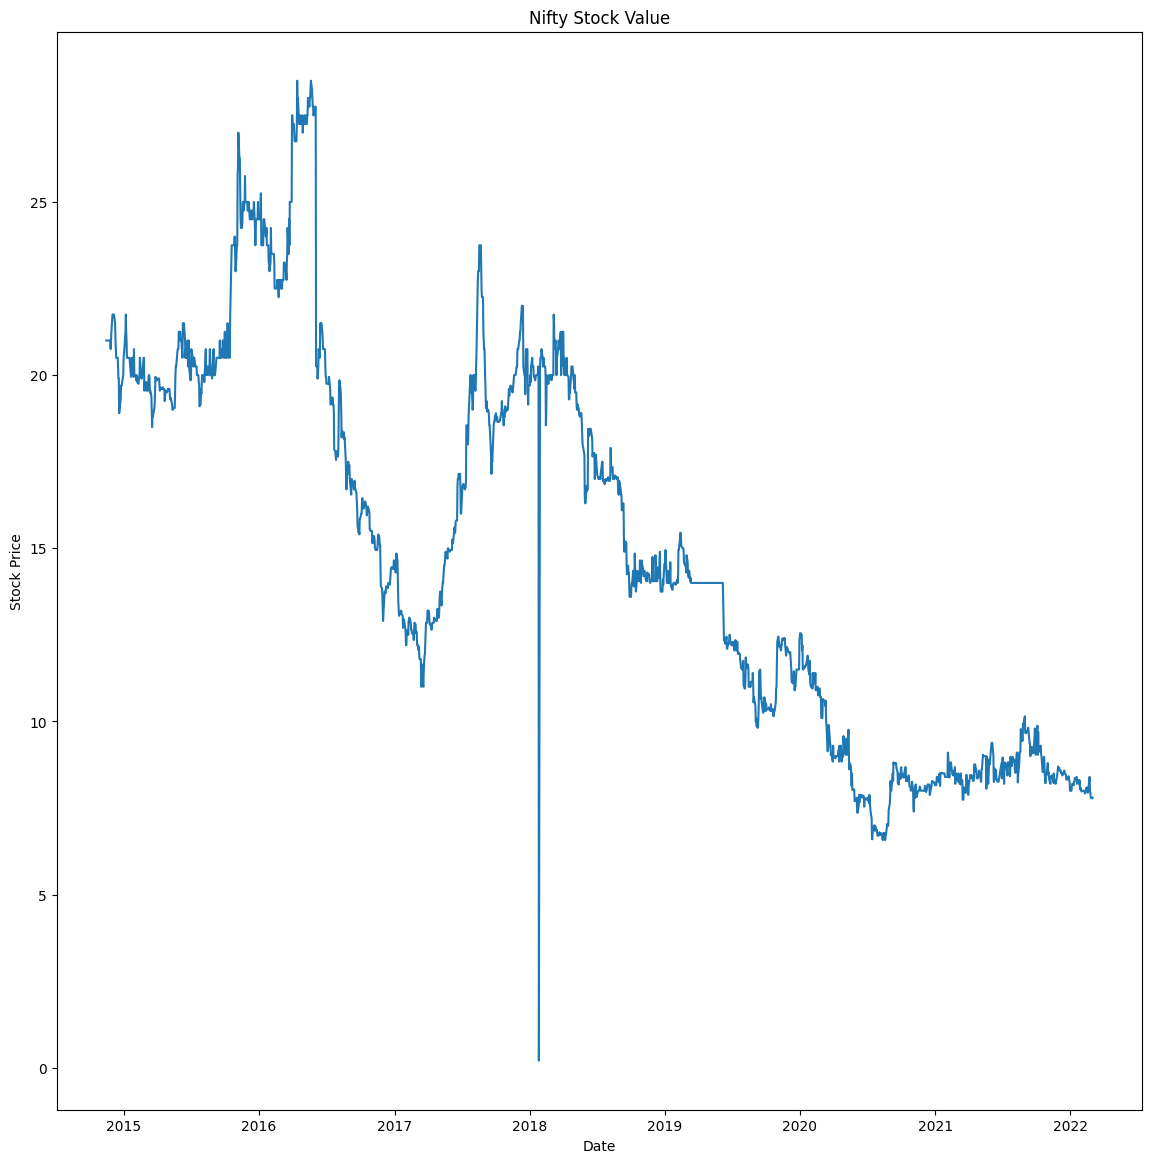

In [27]:
plt.figure(figsize=(14,14))
plt.plot(stk_data['Close'])
plt.title('Nifty Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [28]:
# cleaning up, subsettig
stk_data['Date'] = stk_data.index
nifty_df = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
nifty_df['Date'] = stk_data['Date']
nifty_df['Open'] = stk_data['Open']
nifty_df['High'] = stk_data['High']
nifty_df['Low'] = stk_data['Low']
nifty_df['Close'] = stk_data['Close']

In [29]:
# divide into train and test
# last 2 months as test
test = nifty_df[nifty_df['Date'] > pd.to_datetime('2019-1-1')]
nifty_df = nifty_df[nifty_df['Date'] <= pd.to_datetime('2019-1-1')]

In [30]:
print(test.shape)
print(nifty_df.shape)

(788, 5)
(1034, 5)


## Data Preprocessing

In [31]:
# selecting only the opening price
train_set = nifty_df.iloc[:, 1:2].values
nifty_df.iloc[:, 1:2].tail()

,Open
Date,
2018-12-24,13.75
2018-12-26,13.75
2018-12-27,14.10
2018-12-28,13.95
2018-12-31,14.55


In [32]:
# scaling
sc = MinMaxScaler(feature_range = (-1, 1))

training_set_scaled = sc.fit_transform(train_set)


In [33]:
# preparing data labels
# X - We use the previous 60 days data to create the training set
# Y - the 61st value serves as the Y value
# So standing at any point in time we are looking back 60 days to predict the 61st value

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(-1,1)

In [34]:
# creating test dataset

testdata = test.copy()
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((nifty_df['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test = sc.transform(real_stock_price)

# Simple RNN


In [43]:

import tensorflow as tf
# simple RNN 

model = keras.models.Sequential([
keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics = ['RootMeanSquaredError'])

history = model.fit(x=X_train, y=y_train, batch_size=32,epochs=15, validation_data=(X_test, y_test))

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - RootMeanSquaredError: 1.2204 - loss: 1.4895 - val_RootMeanSquaredError: 1.1676 - val_loss: 1.3633
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 1.2139 - loss: 1.4741 - val_RootMeanSquaredError: 1.1586 - val_loss: 1.3423
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 1.1913 - loss: 1.4193 - val_RootMeanSquaredError: 1.1552 - val_loss: 1.3345
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 1.1562 - loss: 1.3370 - val_RootMeanSquaredError: 1.1547 - val_loss: 1.3334
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 1.1286 - loss: 1.2738 - val_RootMeanSquaredError: 1.1562 - val_loss: 1.3369
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 1.1390 - loss: 1.2987 - val_RootMeanSquaredError: 1.1585 - val_loss: 1.3422
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 1.0693 - loss: 1.1437 - val_RootMeanS

In [44]:
y_pred = sc.inverse_transform(model.predict(X_test))
loss = np.mean(abs(real_stock_price - y_pred))
loss

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


16.273758902162466

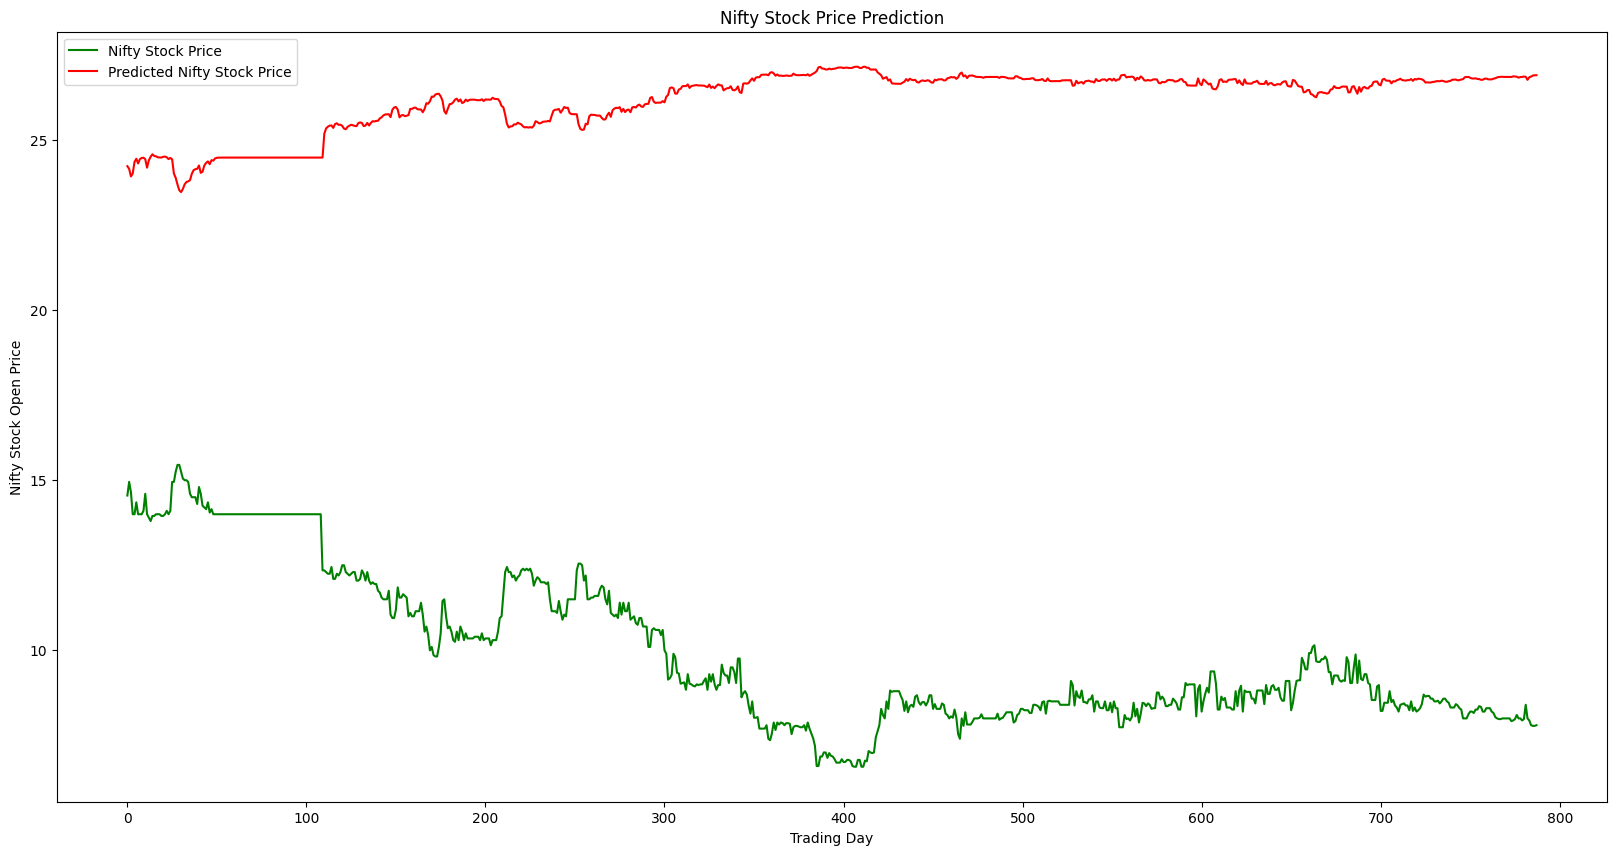

In [45]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'Nifty Stock Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Nifty Stock Price')
plt.title('Nifty Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Nifty Stock Open Price')
#plt.ylim(bottom=0)

plt.legend()
plt.show()

# Deep RNN

In [46]:
# since multiple layers, we can run for more epochs 

model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
1]),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.SimpleRNN(1)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['RootMeanSquaredError'])

history = model.fit(x=X_train, y=y_train, batch_size=32,epochs=100,validation_data=(X_test, y_test))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - RootMeanSquaredError: 1.2035 - loss: 1.4501 - val_RootMeanSquaredError: 0.8601 - val_loss: 0.7397
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - RootMeanSquaredError: 0.7116 - loss: 0.5098 - val_RootMeanSquaredError: 0.4581 - val_loss: 0.2098
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - RootMeanSquaredError: 0.4883 - loss: 0.2387 - val_RootMeanSquaredError: 0.2634 - val_loss: 0.0694
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - RootMeanSquaredError: 0.3204 - loss: 0.1033 - val_RootMeanSquaredError: 0.2585 - val_loss: 0.0668
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - RootMeanSquaredError: 0.2330 - loss: 0.0547 - val_RootMeanSquaredError: 0.1491 - val_loss: 0.0222
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - RootMeanSquaredError: 0.1617 - loss: 0.0262 - val_RootMeanSquaredError: 0.1558 - val_loss: 0.0243
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - RootMeanSquaredError: 0.1689 - loss: 0.0293 - 

In [47]:
y_pred = sc.inverse_transform(model.predict(X_test))
loss = np.mean(abs(real_stock_price - y_pred))

loss

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


1.170238692748365

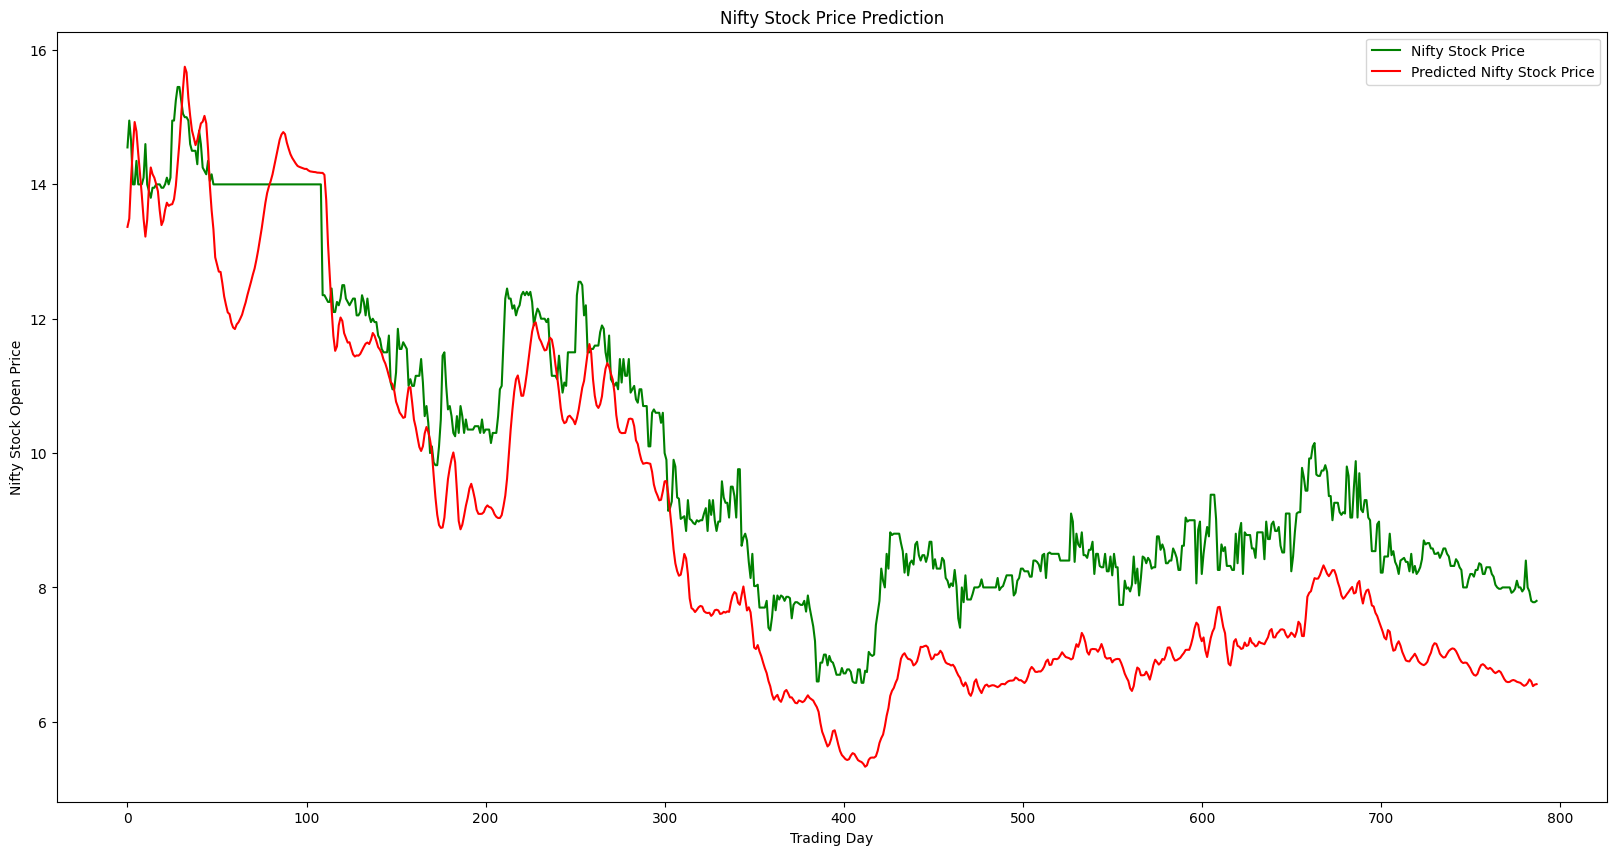

In [48]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'Nifty Stock Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Nifty Stock Price')
plt.title('Nifty Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Nifty Stock Open Price')
#plt.ylim(bottom=0)

plt.legend()
plt.show()

# LSTM Module

In [50]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0548
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0136
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0180
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0115
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0112
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0124
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0088
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0115
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0093
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0096
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0157
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0174
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0110
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0079
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - lo

In [51]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [52]:
loss = np.mean(abs(real_stock_price - predicted_stock_price))
loss

0.375607916546352

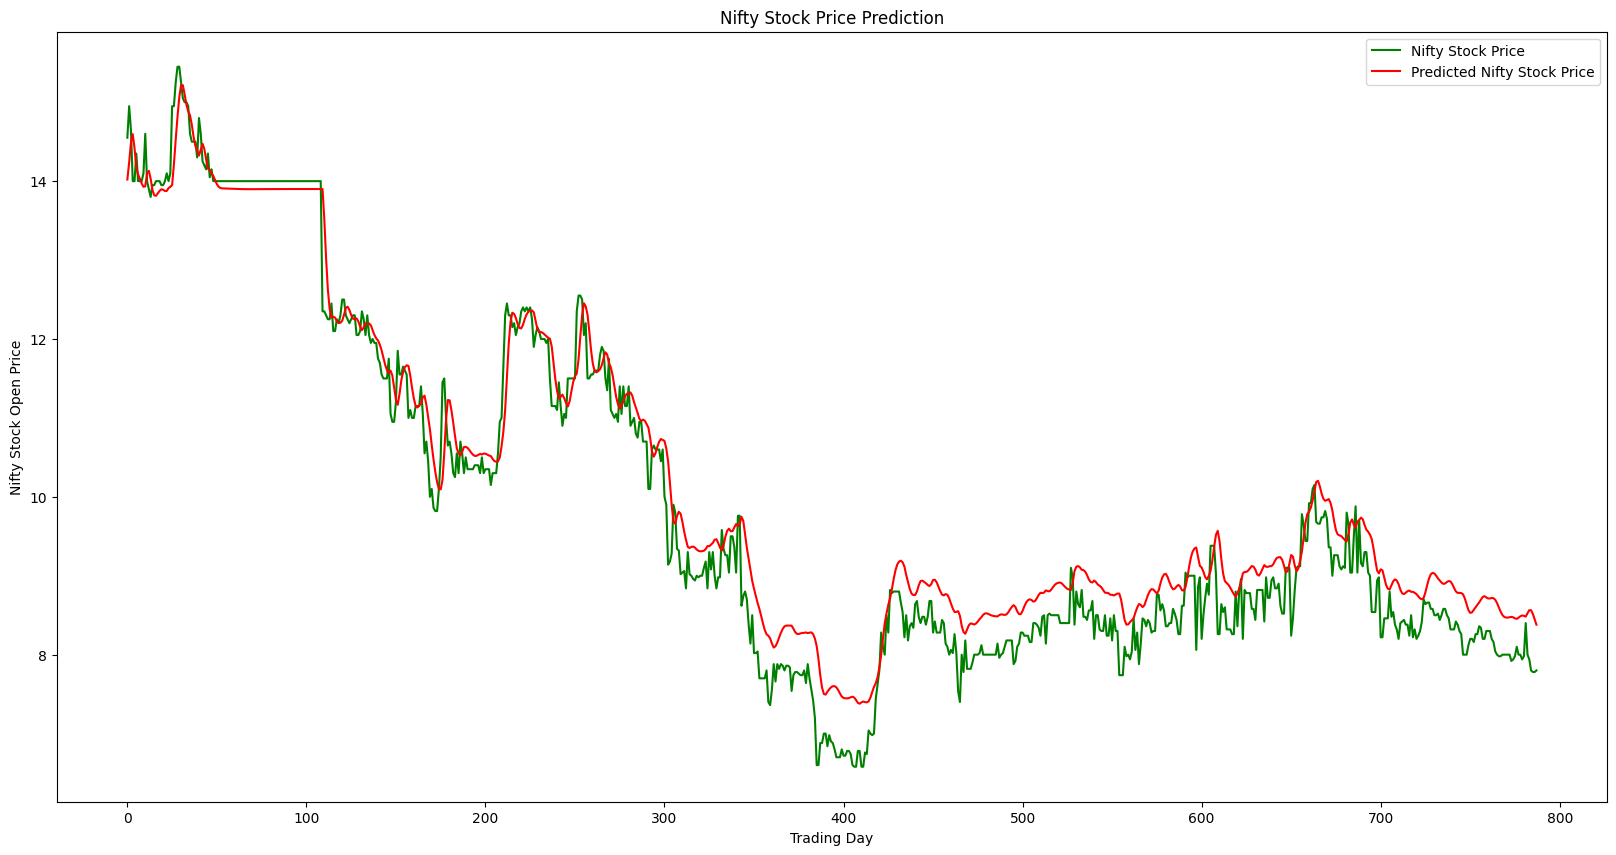

In [53]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'Nifty Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Nifty Stock Price')
plt.title('Nifty Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Nifty Stock Open Price')
#plt.ylim(bottom=0)

plt.legend()
plt.show()